## Load Model and Extract Embeddings Layer

Code taken from https://huggingface.co/spaces/hesamation/primer-llm-embedding?section=embeddings_in_action_%28deepseek-r1-distill-qwen-1.5b%29

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
model_name = tokenizer_name

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Load the pre-trained model
model = AutoModel.from_pretrained(model_name)

# Extract the embeddings layer
embeddings = model.get_input_embeddings()

# Print out the embeddings
print(f"Extracted Embeddings Layer for {model_name}: {embeddings}")

# Save the embeddings layer
torch.save(embeddings.state_dict(), "embeddings_qwen.pth")

Extracted Embeddings Layer for deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B: Embedding(151936, 1536)


In [2]:
import torch.nn as nn

class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(EmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

    def forward(self, input_ids):
        return self.embedding(input_ids)


vocab_size = 151936
dimensions = 1536
embeddings_filename = r"embeddings_qwen.pth"
tokenizer_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Initialize the custom embedding model
model = EmbeddingModel(vocab_size, dimensions)

# Load the saved embeddings from the file
saved_embeddings = torch.load(embeddings_filename)

# Ensure the 'weight' key exists in the saved embeddings dictionary
if 'weight' not in saved_embeddings:
    raise KeyError("The saved embeddings file does not contain 'weight' key.")

embeddings_tensor = saved_embeddings['weight']

# Check if the dimensions match
if embeddings_tensor.size() != (vocab_size, dimensions):
    raise ValueError(f"The dimensions of the loaded embeddings do not match the model's expected dimensions ({vocab_size}, {dimensions}).")

# Assign the extracted embeddings tensor to the model's embedding layer
model.embedding.weight.data = embeddings_tensor

# put the model in eval mode
model.eval()

EmbeddingModel(
  (embedding): Embedding(151936, 1536)
)

### Make embedding retrieval function using saved model

In [3]:
def embedding_retrieval(prompt:str):
    # tokenize the input text
    tokens = tokenizer(prompt, return_tensors="pt")
    input_ids = tokens['input_ids']

    # make a forward pass
    outputs = model(input_ids)

    # directly use the embeddings layer to get embeddings for the input_ids
    embeddings = outputs

    # mean pooling to combine token vectors into one vector per prompt

    # return pooled embeddings as numpy array
    return embeddings.mean(dim =1).detach().numpy()
  

t1 = embedding_retrieval("You are an auto insurance underwriter. A policyholder is a 23 year old male. Their occupation is an actuary and they drive a vehicle that is 10 years old. What is the risk level for this policyholder?")

In [4]:
import tensorflow as tf
t1.shape
#shape of this is one 1536-dim vector

(1, 1536)

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

## Import Data

In [6]:
import seaborn as sns

df = pd.read_csv("freMTPL2freq.csv")

In [7]:
# Create frequency and claim index columns
df["Frequency"] = df["ClaimNb"]/df["Exposure"]
df["ClaimInd"] = df["ClaimNb"] >= 1

In [8]:
df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency,ClaimInd
0,1.0,1,0.10000,D,5,0,55,50,B12,Regular,1217,R82,10.000000,True
1,3.0,1,0.77000,D,5,0,55,50,B12,Regular,1217,R82,1.298701,True
2,5.0,1,0.75000,B,6,2,52,50,B12,Diesel,54,R22,1.333333,True
3,10.0,1,0.09000,B,7,0,46,50,B12,Diesel,76,R72,11.111111,True
4,11.0,1,0.84000,B,7,0,46,50,B12,Diesel,76,R72,1.190476,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0,0.00274,E,4,0,54,50,B12,Regular,3317,R93,0.000000,False
678009,6114327.0,0,0.00274,E,4,0,41,95,B12,Regular,9850,R11,0.000000,False
678010,6114328.0,0,0.00274,D,6,2,45,50,B12,Diesel,1323,R82,0.000000,False
678011,6114329.0,0,0.00274,B,4,0,60,50,B12,Regular,95,R26,0.000000,False


### Split data and work with small subset for computational speed

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(["Frequency"], axis = 1), df["Frequency"], stratify= df["ClaimInd"], test_size=0.2, random_state=42)

In [10]:
X_test

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimInd
673753,6110071.0,0,0.74,E,5,0,25,90,B12,Diesel,3564,R11,False
289208,2190463.0,0,0.53,E,6,10,65,50,B2,Diesel,2278,R91,False
499438,4025340.0,0,0.06,C,8,1,54,50,B12,Diesel,157,R83,False
440941,3164830.0,0,1.00,A,6,2,85,50,B1,Regular,11,R24,False
216301,2038146.0,0,0.02,A,6,3,53,50,B12,Diesel,40,R93,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
598385,5001055.0,2,0.12,D,5,1,81,50,B12,Regular,517,R91,True
523549,4114727.0,0,1.00,A,6,11,53,50,B1,Diesel,28,R83,False
595241,4186419.0,0,0.17,E,7,12,42,50,B11,Diesel,4116,R24,False
168330,1155305.0,0,0.71,C,7,8,32,57,B5,Diesel,220,R53,False


In [11]:
X_test = X_test.reset_index(drop=True)

## Create prompts using raw features

Prompt Structure:

"You are an auto insurance underwriter. A policyholder is {X_test["DrivAge"][i]} years old and lives in area {X_test["Area"][i]} of region {X_test["Region"][i]} with a population density of {X_test["Density"][i]} people per square kilometer. They drive a {X_test["VehBrand"][i]} vehicle that is {X_test["VehAge"][i]} years old, which takes {X_test["VehGas"][i]} gas and is in power class {X_test["VehPower"][i]}. The policyholder has a Bonus-Malus score of {X_test["BonusMalus"][i]}. What is the risk level for this policyholder?"

In [12]:
prompt_list = []
for i in range(len(X_test)):
    prompt_list.append(f"You are an auto insurance underwriter. A policyholder is {X_test["DrivAge"][i]} years old and lives in area {X_test["Area"][i]} of region {X_test["Region"][i]} with a population density of {X_test["Density"][i]} people per square kilometer. They drive a {X_test["VehBrand"][i]} vehicle that is {X_test["VehAge"][i]} years old, which takes {X_test["VehGas"][i]} gas and is in power class {X_test["VehPower"][i]}. The policyholder has a Bonus-Malus score of {X_test["BonusMalus"][i]}. What is the risk level for this policyholder?")

### Retrieve embeddings for all prompts

In [13]:
em_vecs = []

for i in range(len(X_test)):
    em_vecs.append(embedding_retrieval(prompt_list[i]))

em_vecs[:5]

[array([[ 0.0120223 ,  0.00302717,  0.0131409 , ..., -0.0182614 ,
         -0.0015818 , -0.00402434]], shape=(1, 1536), dtype=float32),
 array([[ 0.01136228,  0.00263271,  0.01255052, ..., -0.01822829,
         -0.0018735 , -0.00405941]], shape=(1, 1536), dtype=float32),
 array([[ 0.01097369,  0.00291234,  0.01298736, ..., -0.01754059,
         -0.00124441, -0.00373783]], shape=(1, 1536), dtype=float32),
 array([[ 0.0116713 ,  0.00343947,  0.01378808, ..., -0.01807467,
         -0.00187842, -0.00446554]], shape=(1, 1536), dtype=float32),
 array([[ 0.01137874,  0.00346014,  0.01427841, ..., -0.01726652,
         -0.00111431, -0.00419642]], shape=(1, 1536), dtype=float32)]

In [14]:
emb_mat = np.vstack(em_vecs)
emb_mat

array([[ 0.0120223 ,  0.00302717,  0.0131409 , ..., -0.0182614 ,
        -0.0015818 , -0.00402434],
       [ 0.01136228,  0.00263271,  0.01255052, ..., -0.01822829,
        -0.0018735 , -0.00405941],
       [ 0.01097369,  0.00291234,  0.01298736, ..., -0.01754059,
        -0.00124441, -0.00373783],
       ...,
       [ 0.01332157,  0.00247425,  0.01221506, ..., -0.01983149,
        -0.00136406, -0.00413136],
       [ 0.01094934,  0.002397  ,  0.01351879, ..., -0.01664522,
        -0.00102856, -0.00362222],
       [ 0.01199242,  0.00239452,  0.01330731, ..., -0.01815866,
        -0.0013783 , -0.00424022]], shape=(135603, 1536), dtype=float32)

In [15]:
indtest = np.array([np.array(X_test["ClaimInd"])]).T
indtest

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]], shape=(135603, 1))

In [16]:
new_X = np.hstack((emb_mat, indtest))

In [17]:
pdX = pd.DataFrame(new_X)
pdX[1536]

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
135598    1.0
135599    0.0
135600    0.0
135601    0.0
135602    0.0
Name: 1536, Length: 135603, dtype: float32

In [18]:
Xs = pdX.drop([1536], axis = 1)

### Split data into test and train sets and scale and perform PCA

In [19]:
#stratified pca
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(Xs, y_test, stratify = pdX[1536], test_size=0.2, random_state=42)

In [20]:
scaler = StandardScaler()
X_train2s = scaler.fit_transform(X_train2)
X_test2s = scaler.transform(X_test2)

pca = PCA(n_components=0.95)
X_train2pc = pca.fit_transform(X_train2s)
X_test2pc = pca.transform(X_test2s)

In [21]:
X_train2pc.shape

(108482, 13)

Dimension has been reduced to 13

In [22]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

### Train a NN to predict frequency

In [23]:
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])
model_history = model.fit(
    X_train2pc, y_train2,
    epochs=15,
    batch_size=128,
    validation_split=0.2)

Epoch 1/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - loss: 14.6196 - mae: 0.8912 - val_loss: 7.0436 - val_mae: 0.5838
Epoch 2/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - loss: 13.8223 - mae: 0.6241 - val_loss: 7.1022 - val_mae: 0.6242
Epoch 3/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - loss: 13.7337 - mae: 0.5742 - val_loss: 6.9892 - val_mae: 0.5970
Epoch 4/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step - loss: 13.6968 - mae: 0.5488 - val_loss: 7.2298 - val_mae: 0.8160
Epoch 5/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - loss: 13.6670 - mae: 0.5406 - val_loss: 6.9216 - val_mae: 0.5143
Epoch 6/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - loss: 13.6200 - mae: 0.5145 - val_loss: 6.9089 - val_mae: 0.4142
Epoch 7/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - loss: 13.5973 - mae: 0.5077 - val_loss: 6.9382 - val_mae: 0.4444
Epoch 8/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - loss: 13.5788 - mae: 0.4993 - val_loss: 6.9064 - val_mae: 0.4089
Epoch 9/15
679/679 ━━━━━━━━━━━━━

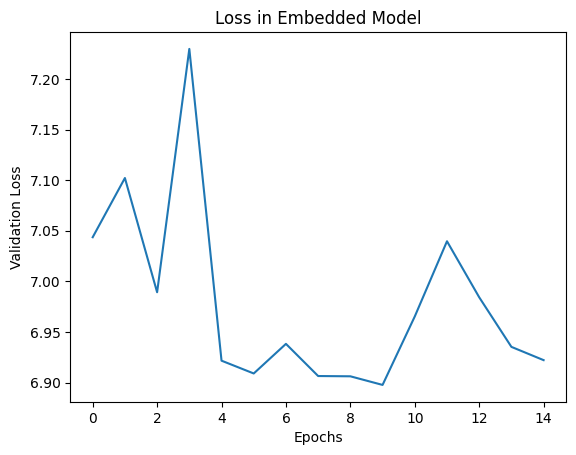

In [24]:
plt.plot(model_history.history['val_loss'])
plt.title('Loss in Embedded Model')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

In [25]:
y_pred = model.predict(X_test2pc)

848/848 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step


In [26]:
y_pred

array([[1.8526196e-01],
       [5.2844584e-03],
       [1.6566345e-01],
       ...,
       [3.3066583e-01],
       [5.4259682e+00],
       [1.6962980e-01]], shape=(27121, 1), dtype=float32)

In [27]:
y_test2 = y_test2.reset_index(drop=True)

In [28]:
loss, mae = model.evaluate(X_test2pc, y_test2)
print(f"Test MAE: {mae}")

predictions = model.predict(X_test2pc)

848/848 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 36.7516 - mae: 0.4844
Test MAE: 0.4843609929084778
848/848 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step


## Perform same procedure for raw data

In [29]:
X_test

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimInd
0,6110071.0,0,0.74,E,5,0,25,90,B12,Diesel,3564,R11,False
1,2190463.0,0,0.53,E,6,10,65,50,B2,Diesel,2278,R91,False
2,4025340.0,0,0.06,C,8,1,54,50,B12,Diesel,157,R83,False
3,3164830.0,0,1.00,A,6,2,85,50,B1,Regular,11,R24,False
4,2038146.0,0,0.02,A,6,3,53,50,B12,Diesel,40,R93,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135598,5001055.0,2,0.12,D,5,1,81,50,B12,Regular,517,R91,True
135599,4114727.0,0,1.00,A,6,11,53,50,B1,Diesel,28,R83,False
135600,4186419.0,0,0.17,E,7,12,42,50,B11,Diesel,4116,R24,False
135601,1155305.0,0,0.71,C,7,8,32,57,B5,Diesel,220,R53,False


In [30]:
y_test

673753     0.000000
289208     0.000000
499438     0.000000
440941     0.000000
216301     0.000000
            ...    
598385    16.666667
523549     0.000000
595241     0.000000
168330     0.000000
200075     0.000000
Name: Frequency, Length: 135603, dtype: float64

In [31]:
freq = np.array([np.array(y_test)]).T

In [32]:
red_X = np.hstack((X_test, freq))

### Create adequate data frame and split then scale

In [33]:
new_Xred = pd.DataFrame(red_X, columns=['IDpol', 'ClaimNb', 'Exposure','Area','VehPower','VehAge','DrvAge','BonusMalus','VehBrand','VehGas','Density','Region','ClaimInd','Frequency'])

In [34]:
X = new_Xred.drop(["IDpol", "ClaimNb", "Exposure", "Frequency", "ClaimInd"], axis = 1)

In [35]:
X = pd.get_dummies(X, columns=['VehGas'])
X = pd.get_dummies(X, columns=['Area'])
X = pd.get_dummies(X, columns=['VehBrand'])
X = pd.get_dummies(X, columns=['Region'])

In [36]:
from sklearn.model_selection import train_test_split
X_trainr, X_testr, y_trainr, y_testr = train_test_split(X, y_test, test_size=0.2, stratify = new_Xred["ClaimInd"], random_state=42)

In [37]:
scaler = StandardScaler()
X_trainsr = scaler.fit_transform(X_trainr)
X_testsr = scaler.transform(X_testr)

### Train the same NN to predict frequency

In [38]:
modelr = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1) 
])
modelr.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])
modelr_history = modelr.fit(
    X_trainsr, y_trainr,
    epochs=15,
    batch_size=128,
    validation_split=0.2)

Epoch 1/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - loss: 13.7216 - mae: 0.4819 - val_loss: 6.8468 - val_mae: 0.4204
Epoch 2/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - loss: 13.6723 - mae: 0.4651 - val_loss: 6.8388 - val_mae: 0.4408
Epoch 3/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - loss: 13.6456 - mae: 0.4649 - val_loss: 6.8322 - val_mae: 0.4294
Epoch 4/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - loss: 13.6291 - mae: 0.4639 - val_loss: 6.8499 - val_mae: 0.4344
Epoch 5/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - loss: 13.6132 - mae: 0.4648 - val_loss: 6.8374 - val_mae: 0.4289
Epoch 6/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - loss: 13.5988 - mae: 0.4649 - val_loss: 6.8341 - val_mae: 0.4003
Epoch 7/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - loss: 13.5775 - mae: 0.4588 - val_loss: 6.8420 - val_mae: 0.4285
Epoch 8/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - loss: 13.5586 - mae: 0.4644 - val_loss: 6.8643 - val_mae: 0.4034
Epoch 9/15
679/679 ━━━━━━━━━━━━━

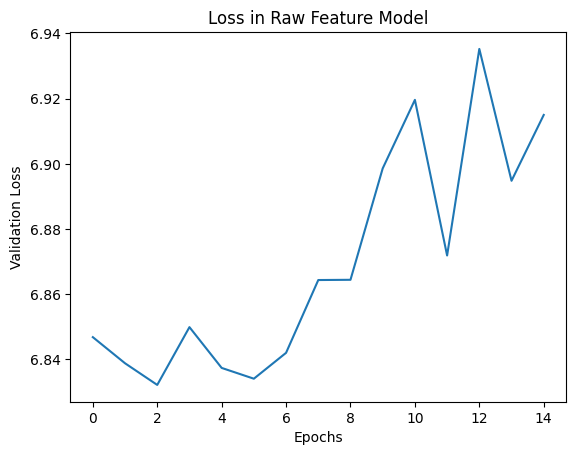

In [39]:
plt.plot(modelr_history.history['val_loss'])
plt.title('Loss in Raw Feature Model')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

Evidence of overfitting

In [40]:
y_predr = modelr.predict(X_testsr)

848/848 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step


In [41]:
y_testr = y_testr.reset_index(drop=True)

In [42]:
loss, mae = modelr.evaluate(X_testsr, y_testr)
print(f"Test MAE: {mae}")

predictions = modelr.predict(X_testsr)

848/848 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 36.6387 - mae: 0.5455
Test MAE: 0.5455410480499268
848/848 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


#### Parameter count

In [43]:
modelr.count_params()

5121

In [44]:
model.count_params()

3009